<a href="https://colab.research.google.com/github/merkelmauer/mirna/blob/main/SimpleVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchinfo
!pip install torchvision
!pip install tensorboard

In [ ]:
link = '/content/drive/MyDrive/master'

# Imports

In [ ]:
import sys
#sys.path.insert(0,'/content/drive/MyDrive/Marko/master')
sys.path.insert(0, link)
import numpy as np
import matplotlib.pyplot as plt


import torch
import torch.optim as optim
import torch.nn as nn
import torch.distributions as dist

from torch.nn import functional as F
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import OneHotEncoder

from tqdm import tqdm
from tqdm import trange

writer = SummaryWriter()


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model Classes

In [ ]:
class diva_args:

    def __init__(self, z_dim=128, d_dim=45, x_dim=15000, y_dim=2,
                 aux_loss_multiplier_y=10, aux_loss_multiplier_d=0,
                 beta=1
                 ):

        self.z_dim = z_dim
        self.d_dim = d_dim
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.aux_loss_multiplier_y = aux_loss_multiplier_y
        self.aux_loss_multiplier_d = aux_loss_multiplier_d
        self.beta = beta

## Dataset Class

In [ ]:
class MicroRNADataset(Dataset):

    def __init__(self, cat_data=True, ds='train'):
        
        # loading images
        
        if not cat_data:
            print('Loading and Converting Images! (~90min)')
            images = np.load(f'/{link}/modmirbase_{ds}_images.npz')['arr_0']/255
            self.images = self.im2col(images, ds)
        else:
            print('Loading Converted Images (~1min)')
            self.images = np.load(f'/{link}/modmirbase_{ds}_images_wbrgby.npz')#['arr_0']
        
        
        # loading labels
        print('Loading Labels! (~10s)')     
        ohe = OneHotEncoder(categories='auto', sparse=False)
        labels = np.load(f'/{link}/modmirbase_{ds}_labels.npz')['arr_0']
        self.labels = ohe.fit_transform(labels)
        
        
        # loading names
        print('Loading Names! (~5s)')
        names =  np.load(f'/{link}/modmirbase_{ds}_names.npz')['arr_0']
        names = [i.decode('utf-8') for i in names]
        self.species = ['mmu', 'prd', 'hsa', 'ptr', 'efu', 'cbn', 'gma', 'pma',
                        'cel', 'gga', 'ipu', 'ptc', 'mdo', 'cgr', 'bta', 'cin', 
                        'ppy', 'ssc', 'ath', 'cfa', 'osa', 'mtr', 'gra', 'mml',
                        'stu', 'bdi', 'rno', 'oan', 'dre', 'aca', 'eca', 'chi',
                        'bmo', 'ggo', 'aly', 'dps', 'mdm', 'ame', 'ppc', 'ssa',
                        'ppt', 'tca', 'dme', 'sbi']
        # assigning a species label to each observation from species
        # with more than 200 observations from past research
        self.names = []
        for i in names:
            append = False
            for j in self.species:
                if j in i.lower():
                    self.names.append(j)
                    append = True
                    break
            if not append:
                if 'random' in i.lower() or i.isdigit():
                    self.names.append('hsa')
                else:
                    self.names.append('notfound')
        
        # performing one hot encoding
        ohe = OneHotEncoder(categories='auto', sparse=False)
        self.names_ohe = ohe.fit_transform(np.array(self.names).reshape(-1,1))
      
    def __len__(self):
        return(self.images.shape[0])

    def __getitem__(self, idx):
        d = self.names_ohe[idx]
        y = self.labels[idx]
        x = self.images[idx]
        x = np.transpose(x, (2,0,1))
        return (x, y, d)

    def im2col(self, images, ds):
        """
        One hot encodes images
        0: black
        1: white
        2: red
        3: green
        4: blue
        5: yellow
        """
        out_shape = (images.shape[0],images.shape[1],images.shape[2],6)
        out_array = np.zeros(out_shape)
        for i in range(out_array.shape[0]):
            print(f'at image {i} out of {out_array.shape[0]}!')
            for j in range(out_array.shape[1]):
                for k in range(out_array.shape[2]):
                    #print(images[i,j,k].shape, images[i,j,k])
                    curr = images[i,j,k]
                    if (curr==np.array([0,0,0])).all():
                        out_array[i,j,k,0] = 1
                    elif (curr==np.array([1,1,1])).all():
                        out_array[i,j,k,1] = 1
                    elif (curr==np.array([1,0,0])).all():
                        out_array[i,j,k,2] = 1
                    elif (curr==np.array([0,1,0])).all():
                        out_array[i,j,k,3] = 1
                    elif (curr==np.array([0,0,1])).all():
                        out_array[i,j,k,4] = 1
                    elif (curr==np.array([1,1,0])).all():
                        out_array[i,j,k,5] = 1
                    else:
                        print("big error!!!")
        print('saving new file!')
        with open(f'/{link}/modmirbase_{ds}_images_wbrgby.npz', 'wb') as f:
            np.save(f, out_array)
        return out_array
                    
                    

## Decoder classes

In [ ]:
# Decoders
class px(nn.Module):
    def __init__(self, d_dim, x_dim, y_dim, z_dim):
        super(px, self).__init__()

        self.fc1 = nn.Sequential(nn.Linear(z_dim, 128, bias=False),
                                 nn.ReLU())
        self.up1 = nn.Upsample(scale_factor=5)
        self.de1 = nn.Sequential(nn.ConvTranspose2d(32, 64, kernel_size=5, stride=1, padding=2, bias=False),
                                 nn.ReLU())
        self.up2 = nn.Upsample(scale_factor=5)
        self.de2 = nn.Sequential(nn.ConvTranspose2d(64, 128, kernel_size=5, stride=1, padding=2, bias=False),
                                 nn.ReLU())
        self.de3 = nn.Sequential(nn.Conv2d(128, 6, kernel_size=1, stride=1),
                                 nn.Softmax(dim=1))

        torch.nn.init.xavier_uniform_(self.fc1[0].weight)
        torch.nn.init.xavier_uniform_(self.de1[0].weight)
        torch.nn.init.xavier_uniform_(self.de2[0].weight)
        torch.nn.init.xavier_uniform_(self.de3[0].weight)
        self.de3[0].bias.data.zero_()

    def forward(self, z):
        h = self.fc1(z)
        h = h.view(-1, 32, 1, 4)
        h = self.up1(h)
        h = self.de1(h)
        h = self.up2(h)
        h = self.de2(h)
        loc_img = self.de3(h)

        return loc_img

In [ ]:
# pzy_ = pzy(45, 7500, 2, 32,32,32)
# summary(pzy_, (1,2))
pzy_ = px(0, 75000, 0, 128)
summary(pzy_, (1,128))

Layer (type:depth-idx)                   Output Shape              Param #
px                                       --                        --
├─Sequential: 1-1                        [1, 128]                  --
│    └─Linear: 2-1                       [1, 128]                  16,384
│    └─ReLU: 2-2                         [1, 128]                  --
├─Upsample: 1-2                          [1, 32, 5, 20]            --
├─Sequential: 1-3                        [1, 64, 5, 20]            --
│    └─ConvTranspose2d: 2-3              [1, 64, 5, 20]            51,200
│    └─ReLU: 2-4                         [1, 64, 5, 20]            --
├─Upsample: 1-4                          [1, 64, 25, 100]          --
├─Sequential: 1-5                        [1, 128, 25, 100]         --
│    └─ConvTranspose2d: 2-5              [1, 128, 25, 100]         204,800
│    └─ReLU: 2-6                         [1, 128, 25, 100]         --
├─Sequential: 1-6                        [1, 6, 25, 100]           --
│ 

## Endcoder Classes

In [ ]:
# Encoders
class qz(nn.Module):
    def __init__(self, d_dim, x_dim, y_dim, z_dim):
        super(qz, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, bias=False),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=5, stride=1, bias=False),
            nn.ReLU(), 
            nn.MaxPool2d(2, 2),
        )

        self.fc11 = nn.Sequential(nn.Linear(2112, z_dim))
        self.fc12 = nn.Sequential(nn.Linear(2112, z_dim), nn.Softplus())

        torch.nn.init.xavier_uniform_(self.encoder[0].weight)
        torch.nn.init.xavier_uniform_(self.encoder[3].weight)
        torch.nn.init.xavier_uniform_(self.fc11[0].weight)
        self.fc11[0].bias.data.zero_()
        torch.nn.init.xavier_uniform_(self.fc12[0].weight)
        self.fc12[0].bias.data.zero_()

    def forward(self, x):
        h = self.encoder(x)
        h = h.view(-1, 2112)
        zd_loc = self.fc11(h)
        zd_scale = self.fc12(h) + 1e-7

        return zd_loc, zd_scale


In [ ]:
_qz = qz(0, 75000, 0, 128)
summary(_qz, (1,6,25,100))

Layer (type:depth-idx)                   Output Shape              Param #
qz                                       --                        --
├─Sequential: 1-1                        [1, 32, 3, 22]            --
│    └─Conv2d: 2-1                       [1, 16, 21, 96]           2,400
│    └─ReLU: 2-2                         [1, 16, 21, 96]           --
│    └─MaxPool2d: 2-3                    [1, 16, 10, 48]           --
│    └─Conv2d: 2-4                       [1, 32, 6, 44]            12,800
│    └─ReLU: 2-5                         [1, 32, 6, 44]            --
│    └─MaxPool2d: 2-6                    [1, 32, 3, 22]            --
├─Sequential: 1-2                        [1, 128]                  --
│    └─Linear: 2-7                       [1, 128]                  270,464
├─Sequential: 1-3                        [1, 128]                  --
│    └─Linear: 2-8                       [1, 128]                  270,464
│    └─Softplus: 2-9                     [1, 128]                  -

## Auxiliary predictors classes

In [ ]:
# Auxiliary tasks
class qd(nn.Module):
    def __init__(self, d_dim, x_dim, y_dim, z_dim):
        super(qd, self).__init__()

        self.fc1 = nn.Linear(z_dim, d_dim)

        torch.nn.init.xavier_uniform_(self.fc1.weight)
        self.fc1.bias.data.zero_()

    def forward(self, zd):
        h = F.relu(zd)
        loc_d = self.fc1(h)

        return loc_d


class qy(nn.Module):
    def __init__(self, d_dim, x_dim, y_dim, z_dim):
        super(qy, self).__init__()

        self.fc1 = nn.Linear(z_dim, y_dim)

        torch.nn.init.xavier_uniform_(self.fc1.weight)
        self.fc1.bias.data.zero_()

    def forward(self, zy):
        h = F.relu(zy)
        loc_y = self.fc1(h)

        return loc_y

## Full model class

In [ ]:
class VAE(nn.Module):
    def __init__(self, args):
        super(VAE, self).__init__()
        self.z_dim = args.z_dim
        self.d_dim = args.d_dim
        self.x_dim = args.x_dim
        self.y_dim = args.y_dim

        self.px = px(self.d_dim, self.x_dim, self.y_dim, self.z_dim)

        self.qz = qz(self.d_dim, self.x_dim, self.y_dim, self.z_dim)

        self.qd = qd(self.d_dim, self.x_dim, self.y_dim, self.z_dim)
        self.qy = qy(self.d_dim, self.x_dim, self.y_dim, self.z_dim)

        self.aux_loss_multiplier_y = args.aux_loss_multiplier_y
        self.aux_loss_multiplier_d = args.aux_loss_multiplier_d

        self.beta = args.beta

        self.cuda()

    def forward(self, d, x, y):
        # Encode
        z_q_loc, z_q_scale = self.qz(x)

        # Reparameterization trick
        qz = dist.Normal(z_q_loc, z_q_scale)
        z_q = qz.rsample()

        # Decode
        x_recon = self.px(z_q)

        # Priors
        z_p_loc, z_p_scale = torch.zeros(z_q.size()[0], self.z_dim).cuda(),\
                               torch.ones(z_q.size()[0], self.z_dim).cuda()
        pz = dist.Normal(z_p_loc, z_p_scale)

        # Auxiliary losses
        d_hat = self.qd(z_q)
        y_hat = self.qy(z_q)

        return x_recon, d_hat, y_hat, qz, pz, z_q

    def loss_function(self, d, x, y):
        x_recon, d_hat, y_hat, qz, pz, z_q = self.forward(d, x, y)

        x_recon = x_recon.view(-1, 6)
        x_target = x.view(-1, 6)
        CE_x = F.cross_entropy(x_recon, x_target, reduction='sum')

        KL_z = torch.sum(pz.log_prob(z_q) - qz.log_prob(z_q))

        _, d_target = d.max(dim=1)
        CE_d = F.cross_entropy(d_hat, d_target, reduction='sum')

        _, y_target = y.max(dim=1)
        CE_y = F.cross_entropy(y_hat, y_target, reduction='sum')

        return CE_x - self.beta * KL_z + self.aux_loss_multiplier_d * CE_d + self.aux_loss_multiplier_y * CE_y, CE_y

    def classifier(self, x):
        """
        classify an image (or a batch of images)
        :param xs: a batch of scaled vectors of pixels from an image
        :return: a batch of the corresponding class labels (as one-hots)
        """
        with torch.no_grad():
            z_q_loc, z_q_scale = self.qz(x)
            z = z_q_loc
            alpha = F.softmax(self.qd(z), dim=1)

            # get the index (digit) that corresponds to
            # the maximum predicted class probability
            res, ind = torch.topk(alpha, 1)

            # convert the digit(s) to one-hot tensor(s)
            d = x.new_zeros(alpha.size())
            d = d.scatter_(1, ind, 1.0)

            alpha = F.softmax(self.qy(z), dim=1)

            # get the index (digit) that corresponds to
            # the maximum predicted class probability
            res, ind = torch.topk(alpha, 1)

            # convert the digit(s) to one-hot tensor(s)
            y = x.new_zeros(alpha.size())
            y = y.scatter_(1, ind, 1.0)

        return d, y

# Training the model

## Initializing model

In [ ]:
default_args = diva_args()

In [ ]:
vae = VAE(default_args).to(DEVICE)

In [ ]:
#diva.load_state_dict(torch.load(f'{link}/diva_v2.5.pth'))

## Loading dataset

In [ ]:
RNA_dataset = MicroRNADataset()


Loading Converted Images (~1min)
Loading Labels! (~10s)
Loading Names! (~5s)


In [ ]:
RNA_dataset_test = MicroRNADataset('test')

Loading Converted Images (~1min)
Loading Labels! (~10s)
Loading Names! (~5s)


In [ ]:
#summary(diva, [(1,45),(1,6,25,100),(1,2)])

## Training functions

In [ ]:
def train_single_epoch(train_loader, model, optimizer, epoch):
    model.train()
    train_loss = 0
    epoch_class_y_loss = 0

    no_batches = 0
    pbar = tqdm(enumerate(train_loader), unit="batch", 
                                     desc=f'Epoch {epoch}')
    for batch_idx, (x, y, d) in pbar:
        # To device
        # print(x)
        # print(y)
        # print(d)
        x, y, d = x.to(DEVICE), y.to(DEVICE), d.to(DEVICE)

        # if (epoch % 50 == 0) and (batch_idx == 1):
        #     save_reconstructions(model, d, x, y)

        optimizer.zero_grad()
        loss, class_y_loss = model.loss_function(d.float(), x.float(), y.float())
        _, y_pred = model.classifier(x.float())
        acc = ((y == y_pred).all(axis=1)*1.0).mean().item()
        writer.add_scalar("Loss/train", loss, epoch)
        writer.add_scalar("y_loss/train", class_y_loss, epoch)
        writer.add_scalar("y_acc/train", acc, epoch)
        loss.backward()
        optimizer.step()
        pbar.set_postfix(loss=loss.item()/x.shape[0], 
                         y_loss = class_y_loss.item()/x.shape[0])
        train_loss += loss
        epoch_class_y_loss += class_y_loss
        no_batches += 1
        # print(f'finished batch {no_batches}!')
        # if no_batches == 25:
        #     break

    train_loss /= len(train_loader.dataset)
    epoch_class_y_loss /= len(train_loader.dataset)

    return train_loss, epoch_class_y_loss

In [ ]:
def test_single_epoch(test_loader, model, epoch):
    model.eval()
    test_loss = 0
    epoch_class_y_loss = 0
    test_corr = 0
        
    with torch.no_grad():
        for batch_idx, (x,y,d) in enumerate(test_loader):
            x, y, d = x.to(DEVICE), y.to(DEVICE), d.to(DEVICE)
            loss, class_y_loss = model.loss_function(d.float(), x.float(), y.float())
            _, y_pred = model.classifier(x.float())
            test_corr += (y == y_pred).all(axis=1).sum().item()
            acc = ((y == y_pred).all(axis=1)*1.).mean().item()
            
            writer.add_scalar("Loss/test", loss, epoch)
            writer.add_scalar("y_loss/test", class_y_loss, epoch)
            writer.add_scalar("y_acc/test", acc, epoch)
            test_loss += loss
            epoch_class_y_loss += class_y_loss
    test_loss /= len(test_loader.dataset)
    epoch_class_y_loss /= len(test_loader.dataset)
    acc = test_corr/len(test_loader.dataset)

    return test_loss, epoch_class_y_loss, acc
  

In [ ]:
def train(train_loader, diva, optimizer, end_epoch, start_epoch=0):
    epoch_loss_sup = []
    epoch_loss_y = []

    y_loss_test = []
    test_loss = []
    test_acc_lst = []

    for epoch in range(start_epoch+1, end_epoch+1):
        avg_epoch_losses_sup, avg_epoch_class_y_loss = train_single_epoch(train_loader, diva, optimizer, epoch)
        str_loss_sup = avg_epoch_losses_sup
        epoch_loss_sup.append(avg_epoch_losses_sup)
        epoch_loss_y.append(avg_epoch_class_y_loss)
        str_print = "epoch {}: avg train loss {}".format(epoch, str_loss_sup)
        str_print += ", class y train loss {}".format(avg_epoch_class_y_loss)
        print(str_print)

        test_lss, epoch_class_y_loss_test, test_acc = test_single_epoch(test_loader, diva, epoch)
        test_loss.append(test_lss)
        y_loss_test.append(epoch_class_y_loss_test)
        test_acc_lst.append(test_acc)
        str_print = "epoch {}: avg test loss {}".format(epoch, test_lss)
        str_print += ", class y test loss {}".format(epoch_class_y_loss_test)
        str_print += ", test accuracy {}".format(test_acc)
        print(str_print)
        
    writer.flush()
    return epoch_loss_sup, epoch_loss_y

## Model Training

In [ ]:
train_loader = DataLoader(RNA_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(RNA_dataset_test, batch_size=128)

In [ ]:
# diva.eval()
# x,y,d = next(enumerate(train_loader))[1]
# x = x.to(DEVICE)
# d_pred, y_pred = diva.classifier(x.float())

In [ ]:
# (y_pred == y.to(DEVICE)).all(axis=1).sum().item()

In [ ]:
optimizer = optim.Adam(vae.parameters(), lr=0.001)

In [ ]:
lss, eplss = train(train_loader, vae, optimizer, 120, 100)

Epoch 101: 272batch [01:01,  4.44batch/s, loss=4.43e+3, y_loss=0.0906]


epoch 101: avg train loss 4426.2548828125, class y train loss 0.12601345777511597
epoch 101: avg test loss 4426.0830078125, class y test loss 0.11172561347484589, test accuracy 0.9718902105354108


Epoch 102: 272batch [01:01,  4.41batch/s, loss=4.42e+3, y_loss=0.108]


epoch 102: avg train loss 4426.07568359375, class y train loss 0.11901376396417618
epoch 102: avg test loss 4425.7841796875, class y test loss 0.12876425683498383, test accuracy 0.94979983295412


Epoch 103: 272batch [01:01,  4.39batch/s, loss=4.43e+3, y_loss=0.318]


epoch 103: avg train loss 4425.94677734375, class y train loss 0.121357262134552
epoch 103: avg test loss 4425.85302734375, class y test loss 0.1182638555765152, test accuracy 0.9616370496241468


Epoch 104: 272batch [01:01,  4.39batch/s, loss=4.43e+3, y_loss=0.22]


epoch 104: avg train loss 4425.94970703125, class y train loss 0.11878436803817749
epoch 104: avg test loss 4425.7333984375, class y test loss 0.12917672097682953, test accuracy 0.9741942916390657


Epoch 105: 272batch [01:01,  4.40batch/s, loss=4.43e+3, y_loss=0.148]


epoch 105: avg train loss 4425.8095703125, class y train loss 0.11919622868299484
epoch 105: avg test loss 4426.09228515625, class y test loss 0.11068164557218552, test accuracy 0.9642003398519627


Epoch 106: 272batch [01:01,  4.40batch/s, loss=4.43e+3, y_loss=0.129]


epoch 106: avg train loss 4425.828125, class y train loss 0.11820089817047119
epoch 106: avg test loss 4425.69677734375, class y test loss 0.12283945828676224, test accuracy 0.9551568215201175


Epoch 107: 272batch [01:01,  4.39batch/s, loss=4.43e+3, y_loss=0.0988]


epoch 107: avg train loss 4425.81005859375, class y train loss 0.11867193877696991
epoch 107: avg test loss 4425.3935546875, class y test loss 0.10917624086141586, test accuracy 0.9726678379078944


Epoch 108: 272batch [01:01,  4.40batch/s, loss=4.43e+3, y_loss=0.248]


epoch 108: avg train loss 4425.6591796875, class y train loss 0.11851505935192108
epoch 108: avg test loss 4425.3701171875, class y test loss 0.11738640069961548, test accuracy 0.9673396503556925


Epoch 109: 272batch [01:01,  4.39batch/s, loss=4.42e+3, y_loss=0.0316]


epoch 109: avg train loss 4425.5146484375, class y train loss 0.11892436444759369
epoch 109: avg test loss 4425.388671875, class y test loss 0.10728367418050766, test accuracy 0.9716598024250453


Epoch 110: 272batch [01:01,  4.41batch/s, loss=4.42e+3, y_loss=0.0256]


epoch 110: avg train loss 4425.47119140625, class y train loss 0.11580397188663483
epoch 110: avg test loss 4425.27490234375, class y test loss 0.10953828692436218, test accuracy 0.9631635033553181


Epoch 111: 272batch [01:01,  4.41batch/s, loss=4.43e+3, y_loss=0.26]


epoch 111: avg train loss 4425.47802734375, class y train loss 0.11586325615644455
epoch 111: avg test loss 4424.9765625, class y test loss 0.11575073003768921, test accuracy 0.9675988594798537


Epoch 112: 272batch [01:01,  4.40batch/s, loss=4.43e+3, y_loss=0.147]


epoch 112: avg train loss 4425.3671875, class y train loss 0.11685682088136673
epoch 112: avg test loss 4425.33740234375, class y test loss 0.11339357495307922, test accuracy 0.9594481725756747


Epoch 113: 272batch [01:01,  4.40batch/s, loss=4.43e+3, y_loss=0.0424]


epoch 113: avg train loss 4425.2998046875, class y train loss 0.11858968436717987
epoch 113: avg test loss 4425.1015625, class y test loss 0.11065749824047089, test accuracy 0.9660724057486824


Epoch 114: 272batch [01:01,  4.41batch/s, loss=4.43e+3, y_loss=0.374]


epoch 114: avg train loss 4425.1943359375, class y train loss 0.11775655299425125
epoch 114: avg test loss 4424.931640625, class y test loss 0.10444515198469162, test accuracy 0.9659860027072953


Epoch 115: 272batch [01:01,  4.40batch/s, loss=4.42e+3, y_loss=0.0431]


epoch 115: avg train loss 4425.1259765625, class y train loss 0.11550169438123703
epoch 115: avg test loss 4424.69287109375, class y test loss 0.10795298963785172, test accuracy 0.9728118429768727


Epoch 116: 272batch [01:01,  4.39batch/s, loss=4.42e+3, y_loss=0.0177]


epoch 116: avg train loss 4425.15087890625, class y train loss 0.11712789535522461
epoch 116: avg test loss 4425.97802734375, class y test loss 0.10626400262117386, test accuracy 0.969672532473143


Epoch 117: 272batch [01:01,  4.40batch/s, loss=4.44e+3, y_loss=0.224]


epoch 117: avg train loss 4424.91796875, class y train loss 0.11442460119724274
epoch 117: avg test loss 4425.07568359375, class y test loss 0.10752453655004501, test accuracy 0.9699317415973042


Epoch 118: 272batch [01:01,  4.40batch/s, loss=4.41e+3, y_loss=0.1]


epoch 118: avg train loss 4424.8935546875, class y train loss 0.11469559371471405
epoch 118: avg test loss 4424.853515625, class y test loss 0.11707602441310883, test accuracy 0.9552720255753002


Epoch 119: 272batch [01:01,  4.40batch/s, loss=4.42e+3, y_loss=0.0848]


epoch 119: avg train loss 4424.9599609375, class y train loss 0.11540640145540237
epoch 119: avg test loss 4424.88134765625, class y test loss 0.11634693294763565, test accuracy 0.9593329685204919


Epoch 120: 272batch [01:01,  4.40batch/s, loss=4.42e+3, y_loss=0.0335]


epoch 120: avg train loss 4424.791015625, class y train loss 0.11367254704236984
epoch 120: avg test loss 4424.40478515625, class y test loss 0.10415253043174744, test accuracy 0.9737334754183348


In [ ]:
#!tensorboard --logdir=runs

In [ ]:
torch.save(vae.state_dict(), f'{link}/vae_v1.2.pth')

# Model Evaluation

## Sampling from trained model

In [ ]:
def sample(x, mean=False):
    """
    takes sample for each pixel given probabilities
    input: reconstructed x (shape: -1,6,25,100)
    output: sample from x (shape: -1,25,100,3)
    """
    color_dict = {1: np.array([1,1,1]), # white
                  0: np.array([0,0,0]), # black
                  2: np.array([1,0,0]), # red
                  3: np.array([0,1,0]), # green
                  4: np.array([0,0,1]), # blue
                  5: np.array([1,1,0])  # yellow
                  }
    out = np.zeros((x.shape[0],x.shape[2],x.shape[3], 3))
    for i in range(x.shape[0]):
      for j in range(x.shape[2]):
        for k in range(x.shape[3]):
          p = x[i,:,j,k]
          p = p.astype(np.float64)
          p += 1e-7
          #print(p)
          p /= p.sum()
          #print(p, sum(p))
          if not mean:
            pix = np.random.choice(np.arange(6), p=p)
          else:
            pix = np.argmax(p)
          out[i,j,k] = color_dict[pix]
    return out

In [ ]:
def decode(x):
    """
    gives image in pixels given x
    input: training x (shape: -1,6,25,100)
    output:  x (shape: -1,25,100,3)
    """
    color_dict = {1: np.array([1,1,1]), # white
              0: np.array([0,0,0]), # black
              2: np.array([1,0,0]), # red
              3: np.array([0,1,0]), # green
              4: np.array([0,0,1]), # blue
              5: np.array([1,1,0])  # yellow
              }
    out = np.zeros((x.shape[0],x.shape[2],x.shape[3], 3))
    for i in range(x.shape[0]):
      for j in range(x.shape[2]):
        for k in range(x.shape[3]):
          for l in range(6):
            if x[i,l,j,k] == 1:
              out[i,j,k] = color_dict[l]
    return out

In [ ]:
a = next(enumerate(train_loader))

In [ ]:
[h.shape for h in a[1]]

[torch.Size([128, 6, 25, 100]), torch.Size([128, 2]), torch.Size([128, 45])]

In [ ]:
with torch.no_grad():
    vae.eval()
    d = a[1][2][:9].to(DEVICE).float()
    x = a[1][0][:9].to(DEVICE).float()
    y = a[1][1][:9].to(DEVICE).float()
    x_recon, _, _, _, _, _ = vae(d,x,y)
    sample_x = sample(x_recon.cpu().numpy(), True)

<Figure size 3600x3600 with 0 Axes>

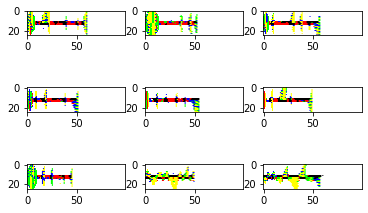

In [ ]:
plt.figure(figsize=(50,50))
fig, ax = plt.subplots(nrows=3, ncols=3)
for i in range(9):
  ax[i//3, i%3].imshow(sample_x[i])

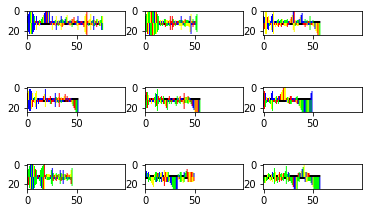

In [ ]:
x_true = decode(x)
fig, ax = plt.subplots(nrows=3, ncols=3)
for i in range(9):
  ax[i//3, i%3].imshow(x_true[i])